# Data exploration of HEST-1K dataset - Xenium subset

In [ ]:
pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=2abaebd0850ff9353c79cf4b2b4a58274d6ef4219b29b43be5f60bdece5623a9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import os
import glob
import re
import scanpy as sc
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data

In [ ]:
# Set local directory fro data reading
data_dir = "/content/drive/My Drive/Projects/Synthetic Spatial Transcriptomics/hest_data_xenium"
st_dir = data_dir + '/st'  # Spatial transcriptomics files (h5ad)
metadata_dir =  data_dir + '/metadata'  # Metadata files (json)
thumbnails_dir = data_dir + '/thumbnails'  # Histology images (jpeg)

In [ ]:
# Iterate over all files in the thumbnails directory
for filename in os.listdir(thumbnails_dir):
    # Only process .jpeg files
    if filename.endswith('.jpeg'):
        # Split the filename at the first underscore
        new_filename = filename.split('_')[0] + '.jpeg'

        # Get the full paths of the current and new filenames
        old_path = os.path.join(thumbnails_dir, filename)
        new_path = os.path.join(thumbnails_dir, new_filename)

        # Rename the file
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')

print("Renaming complete.")


Renamed: NCBI864_downscaled_fullres.jpeg -> NCBI864.jpeg
Renamed: NCBI861_downscaled_fullres.jpeg -> NCBI861.jpeg
Renamed: NCBI860_downscaled_fullres.jpeg -> NCBI860.jpeg
Renamed: NCBI867_downscaled_fullres.jpeg -> NCBI867.jpeg
Renamed: NCBI866_downscaled_fullres.jpeg -> NCBI866.jpeg
Renamed: NCBI859_downscaled_fullres.jpeg -> NCBI859.jpeg
Renamed: NCBI858_downscaled_fullres.jpeg -> NCBI858.jpeg
Renamed: NCBI857_downscaled_fullres.jpeg -> NCBI857.jpeg
Renamed: NCBI785_downscaled_fullres.jpeg -> NCBI785.jpeg
Renamed: NCBI856_downscaled_fullres.jpeg -> NCBI856.jpeg
Renamed: NCBI784_downscaled_fullres.jpeg -> NCBI784.jpeg
Renamed: NCBI783_downscaled_fullres.jpeg -> NCBI783.jpeg
Renamed: TENX134_downscaled_fullres.jpeg -> TENX134.jpeg
Renamed: TENX133_downscaled_fullres.jpeg -> TENX133.jpeg
Renamed: TENX132_downscaled_fullres.jpeg -> TENX132.jpeg
Renamed: TENX127_downscaled_fullres.jpeg -> TENX127.jpeg
Renamed: TENX139_downscaled_fullres.jpeg -> TENX139.jpeg
Renamed: TENX138_downscaled_ful

In [ ]:
# Get all sample identifiers based on the file names (strip the extensions)
sample_ids = set([os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(st_dir, '*.h5ad'))])

# Initialize a dictionary to track the missing files for each sample
missing_files = {}

# Check if each sample has corresponding metadata and thumbnail files
for sample_id in sample_ids:
    st_file = os.path.join(st_dir, f'{sample_id}.h5ad')
    metadata_file = os.path.join(metadata_dir, f'{sample_id}.json')
    thumbnail_file = os.path.join(thumbnails_dir, f'{sample_id}.jpeg')

    missing = []
    if not os.path.exists(st_file):
        missing.append(f'{sample_id}.h5ad')
    if not os.path.exists(metadata_file):
        missing.append(f'{sample_id}.json')
    if not os.path.exists(thumbnail_file):
        missing.append(f'{sample_id}.jpeg')

    if missing:
        missing_files[sample_id] = missing

# Output missing files
if missing_files:
    print("Missing files for the following samples:")
    for sample_id, missing in missing_files.items():
        print(f"{sample_id}: {', '.join(missing)}")
else:
    print("All samples have the required files.")

All samples have the required files.


# Explore data

## Metadata

In [ ]:
# Load metadata file
metadata_file = os.path.join(metadata_dir, f'{sample_id}.json')
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Explore metadata
print(json.dumps(metadata, indent=4))


{
    "pixel_size_um_embedded": 0.2739797412255864,
    "major_version": 2,
    "minor_version": 0,
    "run_name": "PREVIEW: Human Breast Cancer",
    "run_start_time": "2022-09-10T14:03:30Z",
    "region_name": "Sample_2",
    "preservation_method": "FFPE",
    "num_cells": 142272,
    "transcripts_per_cell": 63,
    "transcripts_per_100um": 52.666717964538186,
    "cassette_name": "human_breast_cancer_SIM1",
    "slide_id": "N/A",
    "panel_design_id": "PD_269",
    "panel_name": "Breast Cancer Tumor Microenvironment",
    "panel_organism": "Human",
    "panel_tissue_type": "Breast",
    "panel_num_targets_predesigned": 280,
    "panel_num_targets_custom": 8,
    "pixel_size": 0.2125,
    "instrument_sn": "Xenium prototype instrument",
    "instrument_sw_version": "Development",
    "analysis_sw_version": "xenium-1.4.0.6",
    "experiment_uuid": "",
    "cassette_uuid": "",
    "roi_uuid": "",
    "z_step_size": 3.0,
    "well_uuid": "",
    "calibration_uuid": "ba129c5c-7fb2-475f-

Metadata of interest:
- organ
- disease_state
- species
- tissue

<ipython-input-43-862de30fe5ba>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-43-862de30fe5ba>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-43-862de30fe5ba>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-43-862de30fe5ba>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha="right")


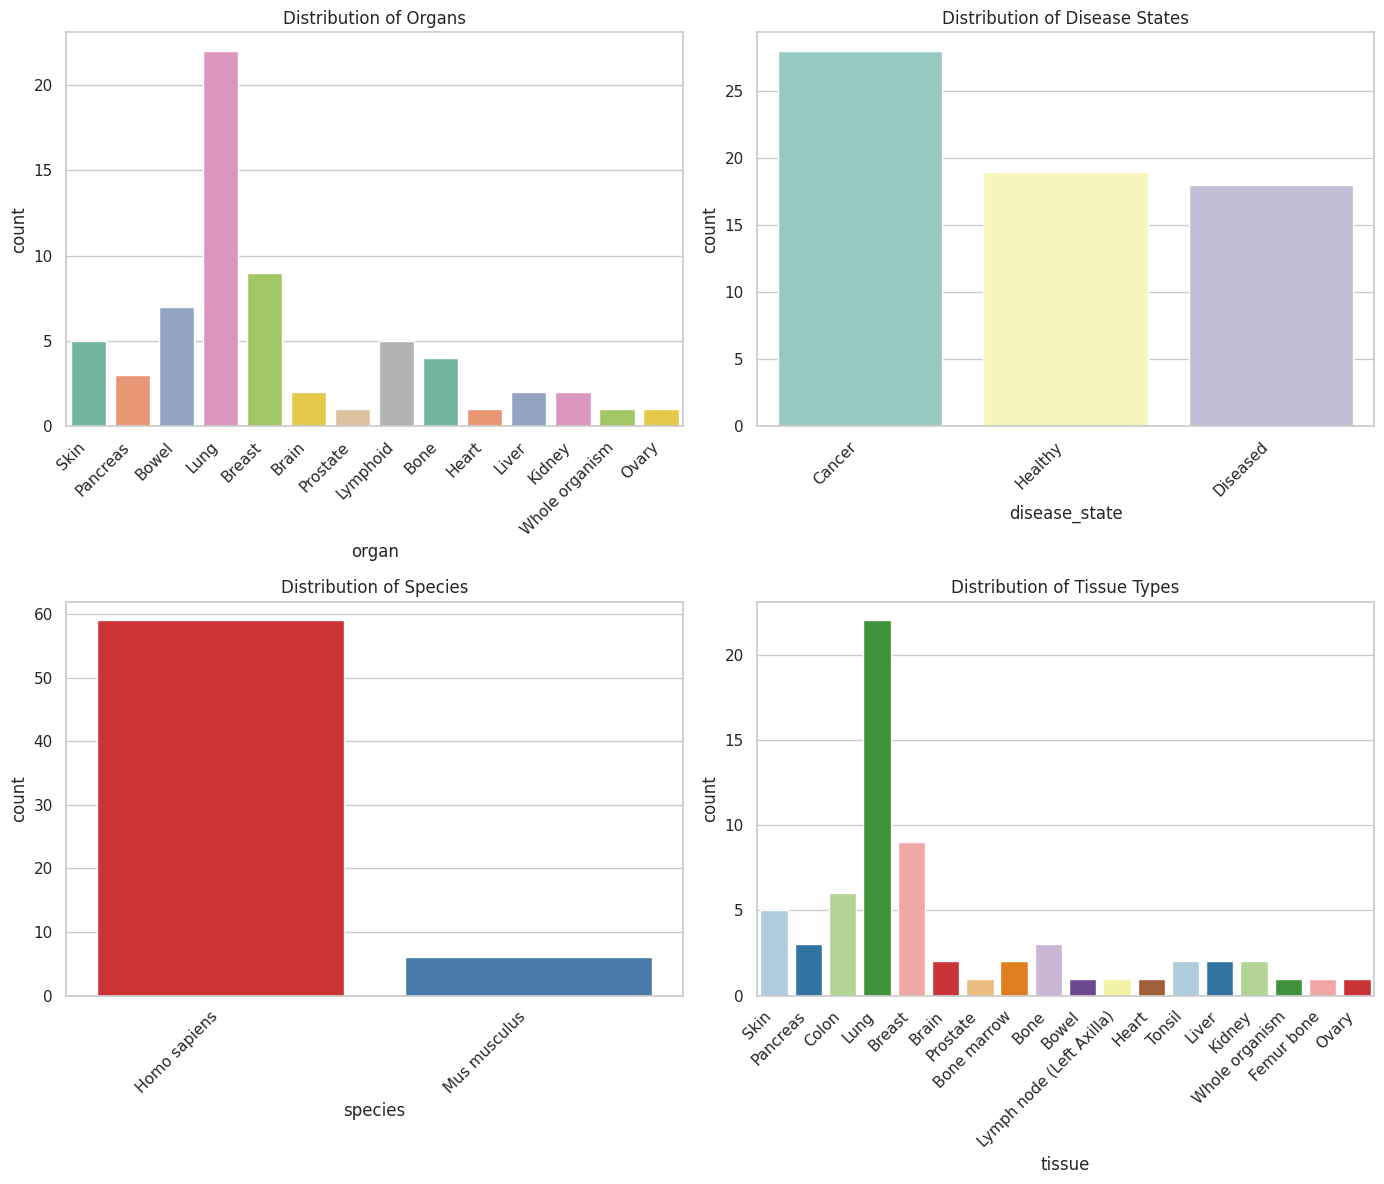

In [ ]:
from glob import glob

# Initialize lists to hold the values for each field
organ = []
disease_state = []
species = []
tissue = []

# Loop through all metadata files and extract the relevant fields
for metadata_file in glob(os.path.join(metadata_dir, '*.json')):
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    # Extract the fields if they exist in the metadata file
    organ.append(metadata.get('organ', None))
    disease_state.append(metadata.get('disease_state', None))
    species.append(metadata.get('species', None))
    tissue.append(metadata.get('tissue', None))

# Create a DataFrame to hold all the metadata
metadata_df = pd.DataFrame({
    'organ': organ,
    'disease_state': disease_state,
    'species': species,
    'tissue': tissue
})

# Clean the data by replacing None values (if any) with 'Unknown'
metadata_df = metadata_df.fillna('Unknown')

# Set the style of the plots
sns.set(style="whitegrid")

# Plot the distribution of each field
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot for 'organ'
sns.countplot(x='organ', data=metadata_df, ax=axes[0, 0], hue='organ', palette="Set2", legend=False)
axes[0, 0].set_title('Distribution of Organs')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha="right")

# Plot for 'disease_state'
sns.countplot(x='disease_state', data=metadata_df, ax=axes[0, 1], hue='disease_state', palette="Set3", legend=False)
axes[0, 1].set_title('Distribution of Disease States')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha="right")

# Plot for 'species'
sns.countplot(x='species', data=metadata_df, ax=axes[1, 0], hue='species', palette="Set1", legend=False)
axes[1, 0].set_title('Distribution of Species')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha="right")

# Plot for 'tissue'
sns.countplot(x='tissue', data=metadata_df, ax=axes[1, 1], hue='tissue', palette="Paired", legend=False)
axes[1, 1].set_title('Distribution of Tissue Types')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha="right")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Histopathology

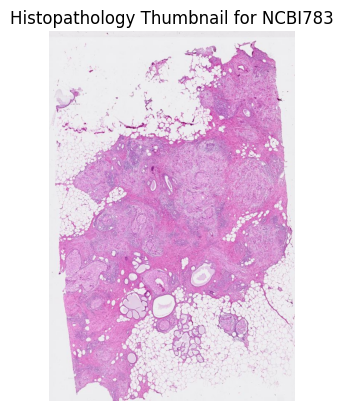

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Find the corresponding thumbnail image file for this sample
thumbnail_file = glob.glob(os.path.join(thumbnails_dir, f'*{sample_id}*.jpeg'))[0]  # Assuming there's at least one match

# Read and display the image
img = mpimg.imread(thumbnail_file)
plt.imshow(img)
plt.title(f'Histopathology Thumbnail for {sample_id}')
plt.axis('off')  # Hide axes for better display
plt.show()


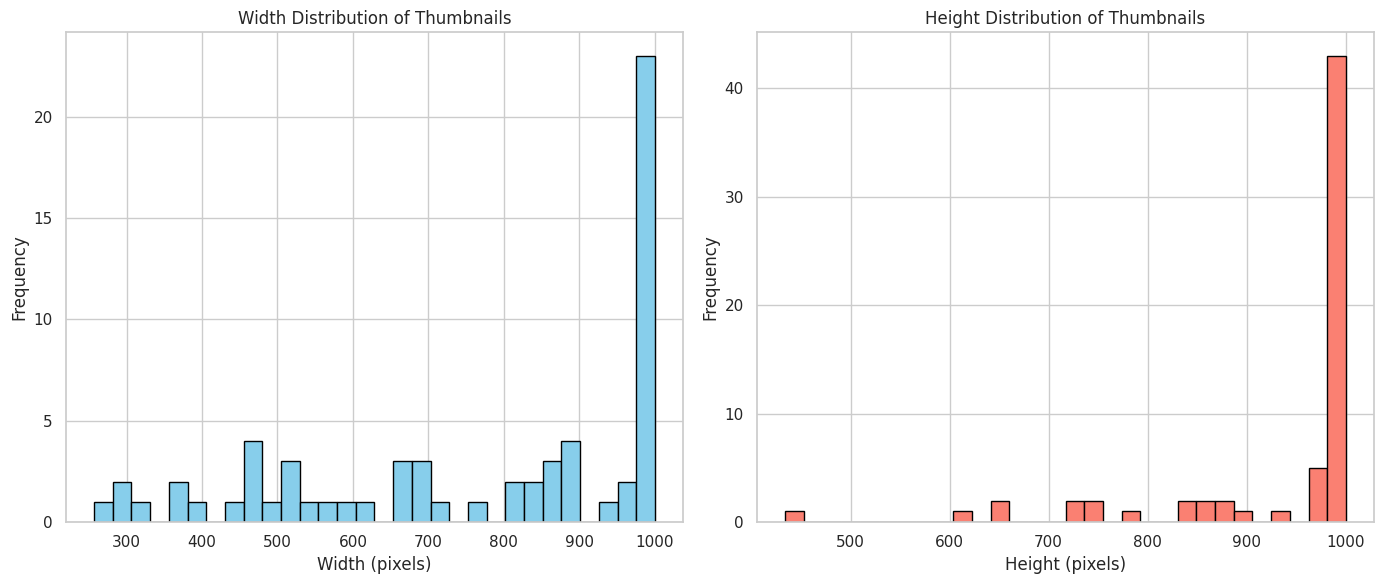

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# List all thumbnail jpeg files in the directory
thumbnail_files = glob(os.path.join(thumbnails_dir, '*.jpeg'))

# Initialize lists to store width and height
widths = []
heights = []

# Loop through each thumbnail file and get its dimensions
for file in thumbnail_files:
    with Image.open(file) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the distributions of width and height
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot width distribution
axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution of Thumbnails')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')

# Plot height distribution
axes[1].hist(heights, bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Height Distribution of Thumbnails')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


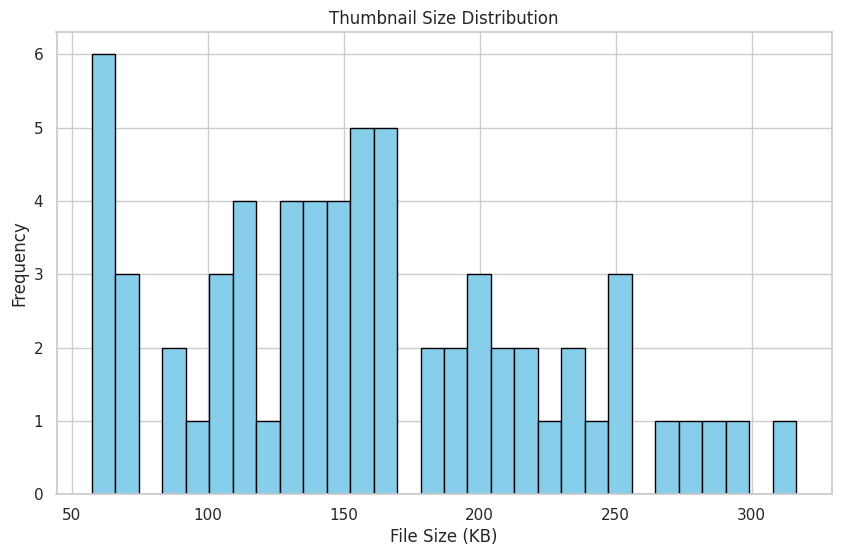

In [ ]:
# List all thumbnail jpeg files in the directory
thumbnail_files = glob(os.path.join(thumbnails_dir, '*.jpeg'))

# Get the file sizes of each thumbnail in bytes
thumbnail_sizes = [os.path.getsize(file) for file in thumbnail_files]

# Convert sizes to kilobytes (for better readability)
thumbnail_sizes_kb = [size / 1024 for size in thumbnail_sizes]

# Plot the size distribution
plt.figure(figsize=(10, 6))
plt.hist(thumbnail_sizes_kb, bins=30, color='skyblue', edgecolor='black')
plt.title('Thumbnail Size Distribution')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Spatial transcriptomics data

In [ ]:
# Load a sample .h5ad file
sample_id = 'NCBI783'  # Example sample ID
st_file = os.path.join(st_dir, f'{sample_id}.h5ad')
adata = sc.read(st_file)


In [ ]:
adata

AnnData object with n_obs × n_vars = 3869 × 541
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

n_obs × n_vars = 3869 × 541: This indicates that the dataset has 3869 observations (spots or locations) and 541 variables (genes). Each observation corresponds to a spot on the tissue slide, and each variable corresponds to a gene.



In [ ]:
adata.obs

,in_tissue,pxl_col_in_fullres,pxl_row_in_fullres,array_col,array_row,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
000x000,True,1187.561863,5007.416421,0,0,11,2.484907,12,2.564949,100.000000,100.000000,100.000000,100.0,0,0.0,0.0
000x001,True,1552.578846,5007.416421,1,0,34,3.555348,48,3.891820,100.000000,100.000000,100.000000,100.0,0,0.0,0.0
000x002,True,1917.595829,5007.416421,2,0,221,5.402677,804,6.690842,62.313433,79.850746,97.388060,100.0,0,0.0,0.0
000x003,True,2282.612811,5007.416421,3,0,213,5.365976,744,6.613384,63.844086,81.720430,98.252688,100.0,0,0.0,0.0
000x004,True,2647.629794,5007.416421,4,0,229,5.438079,746,6.616065,53.887399,75.737265,96.112601,100.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
072x048,True,18708.377031,31288.639173,48,72,2,1.098612,2,1.098612,100.000000,100.000000,100.000000,100.0,0,0.0,0.0
072x049,True,19073.394014,31288.639173,49,72,11,2.484907,11,2.484907,100.000000,100.000000,100.000000,100.0,0,0.0,0.0
072x050,True,19438.410997,31288.639173,50,72,5,1.791759,5,1.791759,100.000000,100.000000,100.000000,100.0,0,0.0,0.0
072x051,True,19803.427979,31288.639173,51,72,3,1.386294,3,1.386294,100.000000,100.000000,100.000000,100.0,0,0.0,0.0


In [ ]:
adata.var

,mito,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
RUNX1,False,3244,47.819850,3.888137,16.154045,185015,12.128198
TCIM,False,3200,30.558025,3.451828,17.291290,118229,11.680387
LUM,False,3269,63.078573,4.160110,15.507883,244051,12.405137
LPXN,False,2826,12.080641,2.571133,26.957870,46740,10.752377
SEC11C,False,2843,22.295425,3.148257,26.518480,86261,11.365144
...,...,...,...,...,...,...,...
BLANK_0130,False,105,0.027914,0.027532,97.286120,108,4.691348
BLANK_0321,False,75,0.019902,0.019706,98.061515,77,4.356709
BLANK_0180,False,43,0.011114,0.011053,98.888602,43,3.784190
BLANK_0319,False,66,0.017059,0.016915,98.294133,66,4.204693
